In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and Process Data

In [14]:
# === Load Features ===
gin_gout_file = "Data_D2/gin_gout_ratio.csv"
df_features = pd.read_csv(gin_gout_file, header=None)
X = df_features.values  # Features: gout/gin ratios

# === Load Labels ===
test_info_file = "Data_D2/test_info.csv"
df_labels = pd.read_csv(test_info_file, header=None)

# Train Test Split and Transform

Unique Capacity (C) values: [12.5 25.  37.5]


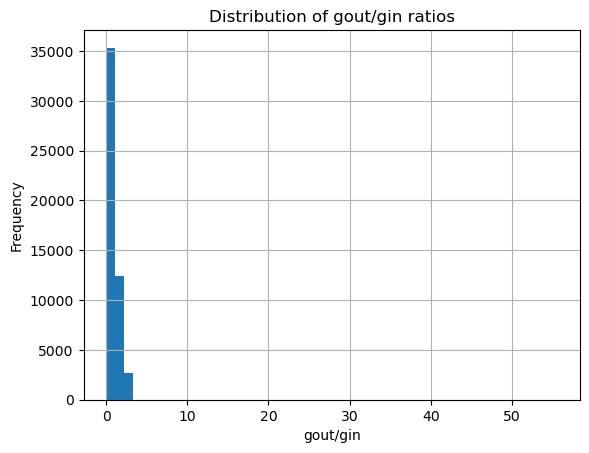

In [15]:
# === Rename columns to match paper notation ===
V_values = df_labels.iloc[:, 0].values  # ✅ V = Capacity (Link Capacity)
C_values = df_labels.iloc[:, 1].values  # ✅ C = Cross Traffic
A_values = V_values - C_values          # ✅ A = Available Bandwidth

# === Debug Print ===
print("Unique Capacity (C) values:", np.unique(C_values))

# === Create Labels Matrix ===
# [A, V] as per the paper (Available Bandwidth, Capacity)
y = np.column_stack((A_values, C_values))  

# === Sanity Check: Match Feature and Label Counts ===
if len(X) != len(y):
    raise ValueError(f"Mismatch: {len(X)} features vs {len(y)} labels.")

# === Normalize A and V using MinMaxScaler ===
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)  # Normalize labels

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_scaled, test_size=0.2, random_state=42
)

# === Visualize Input Feature Distribution ===
plt.hist(X.flatten(), bins=50)
plt.title("Distribution of gout/gin ratios")
plt.xlabel("gout/gin")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Iterative Model

In [16]:
def build_iterative_bandwidth_estimator(k=20):
    model = keras.Sequential([
        layers.Input(shape=(k+2,)),  
        layers.Dense(64, activation='relu'),  # Increased neurons
        layers.Dense(32, activation='relu'),  # Added hidden layer
        layers.Dense(2, activation='linear')  # Output: A and C
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train the Model

In [17]:
# Train the model
iterative_model = build_iterative_bandwidth_estimator(X_train.shape[1])
iterative_model.fit(np.hstack([X_train, np.zeros((X_train.shape[0], 2))]), y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3295 - mae: 0.4566 - val_loss: 0.1566 - val_mae: 0.3297
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1533 - mae: 0.3274 - val_loss: 0.1308 - val_mae: 0.3065
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1338 - mae: 0.3118 - val_loss: 0.1148 - val_mae: 0.2878
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1096 - mae: 0.2796 - val_loss: 0.0839 - val_mae: 0.2414
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0858 - mae: 0.2419 - val_loss: 0.0679 - val_mae: 0.2116
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0690 - mae: 0.2108 - val_loss: 0.0600 - val_mae: 0.1948
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0584 - mae: 0.1890 - val_loss: 0.0518 - val_mae: 0.1739
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0603 - mae: 0.1791 - val_loss: 0.0591 - val_mae: 0.1893
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0493 - mae: 

# Iterative Prediction

In [18]:
def iterative_prediction(model, X, num_iterations=5, initial_A=50, initial_C=100):
    """
    Iteratively refines predictions for A (Available Bandwidth) and C (Capacity).
    
    Args:
    - model: Trained iterative NN model.
    - X: Input feature matrix (g_out/g_in ratios).
    - num_iterations: Number of refinement steps.
    - initial_A: Initial guess for Available Bandwidth.
    - initial_C: Initial guess for Capacity.
    
    Returns:
    - A, C estimates after iterations.
    """
    A_pred = np.full((X.shape[0], 1), initial_A)
    C_pred = np.full((X.shape[0], 1), initial_C)
    
    for _ in range(num_iterations):
        input_data = np.hstack([X, A_pred, C_pred])  # Combine features with previous estimates
        predictions = model.predict(input_data)
        A_pred, C_pred = predictions[:, 0].reshape(-1, 1), predictions[:, 1].reshape(-1, 1)
    
    return A_pred, C_pred

# Print the Results

In [19]:
# Evaluate model
A_pred, C_pred = iterative_prediction(iterative_model, X_test)
mse_A = np.mean((A_pred - y_test[:, 0])**2)
mse_C = np.mean((C_pred - y_test[:, 1])**2)

print(f'MSE for A: {mse_A:.4f}, MSE for C: {mse_C:.4f}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
MSE for A: 0.3066, MSE for C: 0.3090


# Simple NN Model

In [20]:
# Define the model (same as your `build_bandwidth_estimator`)
def build_bandwidth_estimator(k=25):
    model = keras.Sequential([
        layers.Input(shape=(k,)),  # Input layer (expects 20 features)
        layers.Dense(40, activation='relu'),  # Hidden layer with 40 neurons
        layers.Dense(2, activation='linear')  # Output layer (predicts A and C)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Ensure input dimension matches model expectation
k = X_train.shape[1]
model = build_bandwidth_estimator(k)
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 40)                  │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              82 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 962 (3.76 KB)

 Trainable params: 962 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2806 - mae: 0.4301 - val_loss: 0.1584 - val_mae: 0.3368
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1606 - mae: 0.3421 - val_loss: 0.1355 - val_mae: 0.3109
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1347 - mae: 0.3143 - val_loss: 0.1229 - val_mae: 0.3017
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1184 - mae: 0.2962 - val_loss: 0.0989 - val_mae: 0.2685
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0977 - mae: 0.2652 - val_loss: 0.0855 - val_mae: 0.2474
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0859 - mae: 0.2492 - val_loss: 0.0746 - val_mae: 0.2254
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0774 - mae: 0.2322 - val_loss: 0.0792 - val_mae: 0.2369
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0706 - mae: 0.2169 - val_loss: 0.0650 - val_mae: 0.2074
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0625 - mae: 

In [21]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict Available Bandwidth (A) and Capacity (C)
predictions = model.predict(X_test)
print("Predicted A and C values:\n", predictions)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0290 - mae: 0.1215
Test Loss: 0.033707037568092346, Test MAE: 0.12924696505069733
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
Predicted A and C values:
 [[-6.57965839e-02  1.06610239e+00]
 [-5.50956726e-02  1.06178284e+00]
 [ 4.23655689e-01  5.67209959e-01]
 [-7.87045807e-02  1.08760095e+00]
 [-1.69809759e-02  1.03531253e+00]
 [ 7.25838780e-01  2.94460356e-01]
 [ 5.99412501e-01  4.53661025e-01]
 [-4.25507575e-02  1.02742195e+00]
 [ 4.08789009e-01  5.94807565e-01]
 [ 6.22788072e-01  4.07954514e-01]
 [ 9.71300155e-03  9.92035985e-01]
 [ 6.08516693e-01  3.90532553e-01]
 [ 7.36405134e-01  1.08516172e-01]
 [ 5.77846289e-01  4.57363188e-01]
 [-3.92228365e-03  1.02021551e+00]
 [ 1.05185151e-01  9.12805080e-01]
 [ 1.19710243e+00 -2.22897574e-01]
 [ 5.61282486e-02  9.39897656e-01]
 [ 6.48713708e-01  4.03348625e-01]
 [ 3.79506409e-01  6.27077460e-01]
 [ 6.13059461e-01  3.89231443e-01]
 [-4.49754894e-02  1.05191851e+00]
 [ 6.28788650e-01  3.76649976

In [22]:
# === Inverse transform scaled predictions and true labels ===
y_test_actual = scaler.inverse_transform(y_test)
simple_preds_actual = scaler.inverse_transform(predictions)
iter_preds_actual = scaler.inverse_transform(np.hstack([A_pred, C_pred]))

# === Extract values ===
A_true = y_test_actual[:, 0]            # Available Bandwidth
C_true = y_test_actual[:, 1]            # Cross Traffic (C)

A_simple = simple_preds_actual[:, 0]
C_simple = simple_preds_actual[:, 1]

A_iterative = iter_preds_actual[:, 0]
C_iterative = iter_preds_actual[:, 1]

# === Comparison DataFrame ===
df_C_comparison = pd.DataFrame({
    "True C (Cross Traffic)": C_true,
    "Predicted C (Simple NN)": C_simple,
    "Predicted C (Iterative NN)": C_iterative
})

# === Show Comparison ===
print(df_C_comparison.head(20))
print("\nUnique Cross Traffic values in this batch:", np.unique(C_true))

    True C (Cross Traffic)  Predicted C (Simple NN)  \
0                     37.5                39.152561   
1                     37.5                39.044571   
2                     25.0                26.680248   
3                     37.5                39.690025   
4                     37.5                38.382812   
5                     12.5                19.861509   
6                     25.0                23.841526   
7                     37.5                38.185547   
8                     25.0                27.370190   
9                     25.0                22.698862   
10                    37.5                37.300900   
11                    12.5                22.263313   
12                    25.0                15.212904   
13                    25.0                23.934080   
14                    37.5                38.005386   
15                    37.5                35.320126   
16                    12.5                 6.927560   
17        

In [34]:
def plot_grouped_C_predictions(true_C, pred_C_dict, bin_width=25):
    bins = np.arange(0, np.ceil(true_C.max()) + bin_width, bin_width)
    bin_centers = bins[:-1] + bin_width / 2

    plt.figure(figsize=(8, 5))
    max_pred_value = 0  # to determine max for setting reference line

    for label, pred_C in pred_C_dict.items():
        means, stds = [], []
        for i in range(len(bins)-1):
            if i == len(bins) - 1:
                mask = (true_C >= bins[i]) & (true_C <= bins[i + 1])
            else:
                mask = (true_C >= bins[i]) & (true_C < bins[i + 1])

            if np.any(mask):
                mean_val = np.mean(pred_C[mask])
                std_val = np.std(pred_C[mask])
                means.append(mean_val)
                stds.append(std_val)
                max_pred_value = max(max_pred_value, mean_val + std_val)
            else:
                means.append(np.nan)
                stds.append(np.nan)

        plt.errorbar(bin_centers, means, yerr=stds, fmt='o-', capsize=5, label=label)

    # Add y = x reference line
    max_range = max(np.nanmax(true_C), max_pred_value)
    plt.plot([0, max_range], [0, max_range], 'k--', label="Ideal (y = x)")

    plt.xlabel("True Cross Traffic (C) [Mbps]")
    plt.ylabel("Predicted Cross Traffic [Mbps]")
    plt.title("Grouped Cross Traffic Predictions with Error Bars")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xlim(0, np.ceil(max_range))
    plt.ylim(0, np.ceil(max_range))
    plt.show()


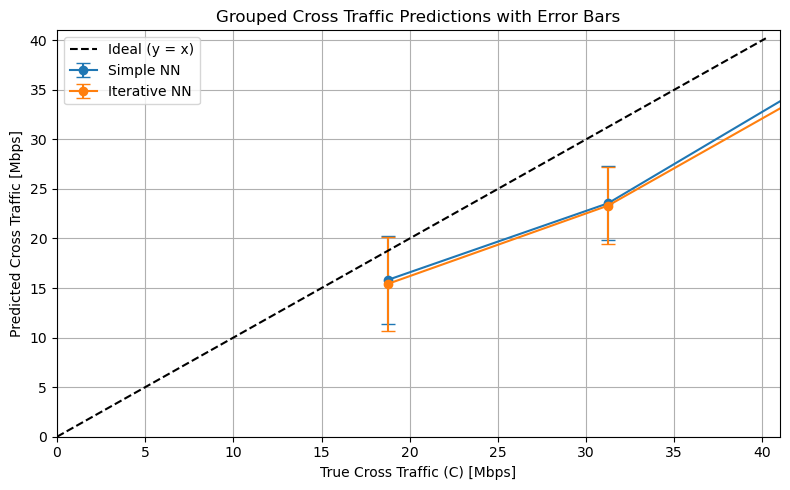

In [35]:
plot_grouped_C_predictions(
    C_true,
    {
        "Simple NN": C_simple,
        "Iterative NN": C_iterative
    },
    bin_width=12.5
)
